R-peak Validation (clean, module-based)
- TDMS ECG load via hrv_epatch.io.tdms_pipeline
- RR (.lvm) via hrv_epatch.rpeak.validate
- Peak detection (NeuroKit2) + event metrics with lag & tolerance
- Small overlay plot for a quick sanity check

In [3]:
# %% imports
# from src.hrv_epatch.io.tdms import extract_tdms_channel
# from src.hrv_epatch.io.labview import read_labview_rr, read_header_datetime_lvm, rr_to_peak_samples
# from src.hrv_epatch.rpeak.metrics import event_metrics_overlap_lag, overlay_with_padding

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

# === your structured modules ===
# IO (TDMS)
from src.hrv_epatch.io.tdms_pipeline import load_tdms
# R-peak validation helpers (RR I/O, peak detection, metrics, etc.)
from src.hrv_epatch.rpeak.validate import (
    read_labview_rr,
    read_header_datetime_lvm,
    rr_to_peak_samples,
    detect_ecg_peaks,
    event_metrics_overlap_lag,
)
from src.hrv_epatch.plots.rpeak_compare import plot_comparison_window

# CONFIG
- Set these two paths to your recording & LabVIEW RR file.
- `override_offset_s` can force an offset (seconds) if auto-compute fails.

In [4]:

# File paths
TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"

# Optional manual override (None = auto from header times)
override_offset_s: Optional[float] = None

# Detection / evaluation params
fs_hint: Optional[float] = None   # normally read from TDMS; keep None unless you must override
tol_ms = 40.0                     # symmetric tolerance window ± (ms)
max_lag_ms = 150.0                # search small lag up to ± (ms) during evaluation

# Small plot window (global seconds)
preview_start_s = 10_000.0
preview_dur_s   = 20.0

# 1) Load ECG from TDMS

In [5]:
# load_tdms returns (signal: np.ndarray, meta: RecordingMeta)
# meta.fs, meta.start_time (tz-aware Europe/Copenhagen), meta.n_samples, ...
ecg_raw, meta = load_tdms(TDMS_PATH, channel_hint="EKG")  # change hint if needed
fs = float(meta.fs) if meta.fs else float(fs_hint or 512.0)
print(f"TDMS loaded: n={len(ecg_raw)}, fs={fs}, start={meta.start_time}, channel={meta.channel_name}")

TDMS loaded: n=82460288, fs=512.0, start=2016-10-12 11:05:02, channel=EKG


# 2) Read LabVIEW RR (.lvm) & compute time offset
We try to parse `Date` + `Time` from the LVM header.  
If both `TDMS start_time` and `LVM header time` are present, we compute:
`offset_s = (LVM_time - TDMS_start_time).total_seconds()`.  
You can always override with `override_offset_s`.

In [6]:
def compute_offset_seconds(tdms_start_dt, lvm_header_dt) -> Optional[float]:
    """Return seconds(LVM - TDMS). Handles tz-aware/naive safely."""
    if tdms_start_dt is None or lvm_header_dt is None:
        return None
    # tdms_start_dt is tz-aware (Europe/Copenhagen) in our pipeline
    # lvm_header_dt is naive; assume it's local Europe/Copenhagen wall time
    try:
        import pandas as _pd
        tdms = _pd.to_datetime(tdms_start_dt)
        lvm  = _pd.to_datetime(lvm_header_dt)
        if tdms.tzinfo is None:
            # localize to Europe/Copenhagen for TDMS if missing (shouldn't be)
            tdms = tdms.tz_localize("Europe/Copenhagen")
        if lvm.tzinfo is None:
            # LabVIEW header time treated as local (Europe/Copenhagen)
            lvm = lvm.tz_localize("Europe/Copenhagen")
        dt = (lvm - tdms).total_seconds()
        return float(dt)
    except Exception:
        return None

# Read RR and (optionally) header time
rr_s = read_labview_rr(LVM_PATH, skiprows=22)  # robust reader (handles comma/dot decimals, ms/us)
lvm_header_dt = read_header_datetime_lvm(LVM_PATH)  # naive datetime or None
auto_offset_s = compute_offset_seconds(meta.start_time, lvm_header_dt)
offset_s = override_offset_s if override_offset_s is not None else auto_offset_s

print(f"RR count: {len(rr_s)}")
print(f"LVM header time: {lvm_header_dt}")
print(f"Auto-computed offset (LVM - TDMS): {offset_s} s")

if offset_s is None:
    raise RuntimeError(
        "Could not determine TDMS↔LVM offset automatically. "
        "Set `override_offset_s = ...` in the CONFIG cell."
    )

RR count: 186084
LVM header time: 2016-10-12 11:06:19.181654
Auto-computed offset (LVM - TDMS): 77.181654 s


# 3) RR → global sample indices (LabVIEW peaks)
We assume the **first** LabVIEW R-peak occurs `offset_s` seconds after TDMS start.

In [7]:
lab_idx = rr_to_peak_samples(rr_s, fs=fs, t0_s=offset_s)
print(f"First/last LabVIEW peak (samples): {lab_idx[0]} .. {lab_idx[-1]}")

First/last LabVIEW peak (samples): 39517 .. 82310251


# 4) Detect R-peaks on ECG (NeuroKit2)

In [8]:
nk_idx = detect_ecg_peaks(pd.Series(ecg_raw, name=meta.channel_name), fs=fs)
print(f"Detected NK peaks: {len(nk_idx)}")

Detected NK peaks: 167188


# 5) Evaluate with lag & tolerance
We crop to overlapping region, search a small best lag (±{max_lag_ms} ms),
then compute TP/FP/FN + Sensitivity/PPV/F1 with tolerance ±{tol_ms} ms.

In [9]:
metrics = event_metrics_overlap_lag(
    gold_idx = lab_idx,
    test_idx = nk_idx,
    fs       = fs,
    tol_ms   = tol_ms,
    max_lag_ms = max_lag_ms,
)
print(metrics)

{'TP': 14982, 'FP': 152090, 'FN': 171101, 'Sensitivity': 0.08051245949388176, 'PPV': 0.08967391304347826, 'F1': 0.08484659710325494, 'lag_samples': -35, 'tol_samples': 20, 'N_overlap': 82270699, 'lo': np.int64(39517), 'hi': np.int64(82310216)}


# 6) Quick overlay plot (preview window)

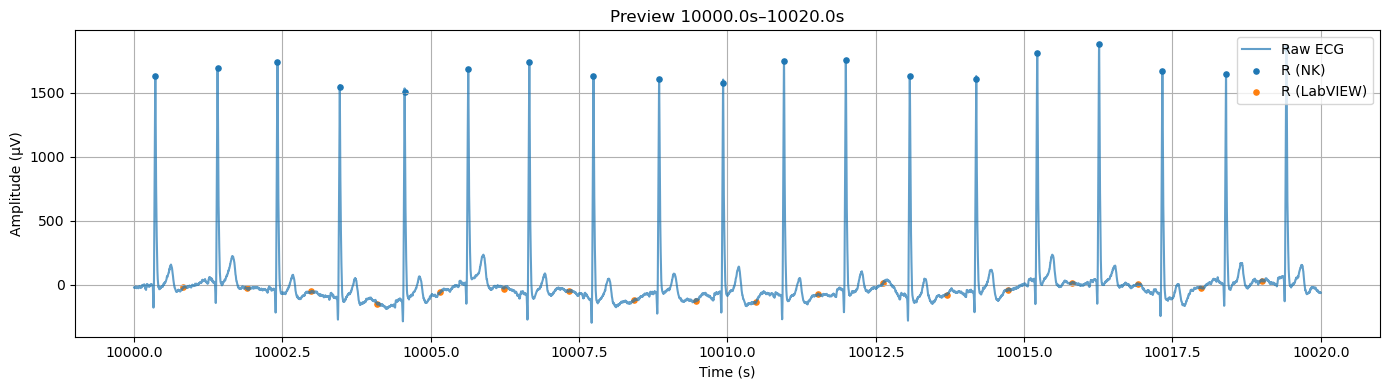

In [10]:
s = int(preview_start_s * fs)
e = int((preview_start_s + preview_dur_s) * fs)
t = np.arange(s, e) / fs

raw_win = ecg_raw[s:e]

lab_loc = lab_idx[(lab_idx >= s) & (lab_idx < e)] - s
nk_loc  = nk_idx[(nk_idx  >= s) & (nk_idx  < e)] - s

plt.figure(figsize=(14, 4))
plt.plot(t, raw_win, label="Raw ECG", alpha=0.7)
plt.scatter(t[nk_loc],  raw_win[nk_loc],  s=14, label="R (NK)")
plt.scatter(t[lab_loc], raw_win[lab_loc], s=14, label="R (LabVIEW)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.title(f"Preview {preview_start_s:.1f}s–{(preview_start_s+preview_dur_s):.1f}s")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# 7) (Optional) Save metrics
# You can dump `metrics` to JSON/CSV if you want a trail across patients.

In [11]:
# import json, pathlib
# out = pathlib.Path("outputs") ; out.mkdir(exist_ok=True, parents=True)
# (out/"rpeak_metrics.json").write_text(json.dumps(metrics, indent=2))

# 8) Different plots

In [12]:
from src.hrv_epatch.plots.rpeak import plot_comparison_window, plot_raw_vs_clean_with_peaks, Window

# eksempel:
fig = plot_comparison_window(
    ecg=x_all, fs=fs,
    nk_idx=nk_idx_raw,
    lab_idx_refined=lab_idx_refined,
    lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=120.0,
    cleaned=x_clean,
    title="Comparison window 73288.0–73408.0s",
)


NameError: name 'x_all' is not defined